## Sentiment Classification using fastai

* fastai is a library built on top of PyTorch, which simplifies the task of training fast and accurate neural networks.
* fastai provides models such as text, vision, tabular, collab.

### `text` model
The text module of the fastai library contains all the necessary functions to define a Dataset suitable for the various NLP tasks
* `text.transform` contains all the scripts to preprocess your data, from raw text to token ids,
* `text.data contains` the definition of TextDataBunch, which the main class you'll need in NLP,
![](http://)* `text.learner contains` helper functions to quickly create a language model or an RNN classifier

In [1]:
import torch
import torch.nn as nn
import fastai
from fastai.text import *
import pandas as pd

import os
print(os.listdir('../input/'))

['IMDB Dataset.csv']


Dataset: Small sample of the IMDB dataset which contains 1,000 reviews of movies with labels (positive or negative).

In [2]:
path = untar_data(URLs.IMDB_SAMPLE)
path

PosixPath('/tmp/.fastai/data/imdb_sample')

In [3]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


<Figure size 432x288 with 0 Axes>

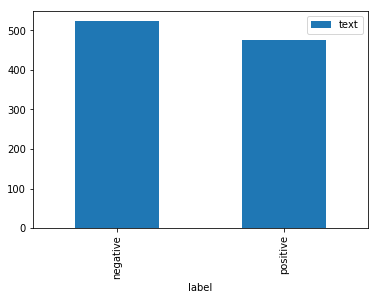

In [26]:
fig = plt.figure()
df = df.drop('is_valid', axis=1)
df.groupby('label').count().plot.bar(ylim=0)
plt.show()

## Preparing Data for modelling
* fastai has `TextDataBunch` class which takes care of loading, splitting the data intro test and train sets, preprocessing the data (Creating vocabulary, tokanizing etc.).
* `TextDataBunch` has two subclasses `TextLMDataBunch` (Language model data) and `TextClasDataBunch` (Text classifier data).

For the classifier, we also pass the vocabulary (mapping from ids to words) that we want to use: this is to ensure that `data_clas` will use the same dictionary as `data_lm`

In [4]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv', device='cuda')
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'texts.csv', vocab=data_lm.train_ds.vocab, device='cuda', bs=32)

In [6]:
print(data_lm)

TextLMDataBunch;

Train: LabelList (799 items)
x: LMTextList
xxbos xxmaj evil xxmaj breed is a very strange slasher flick that is unfortunately no good . xxmaj the beginning of the film seems promising but overall it 's a disaster . xxmaj the dialogue is pretty bad but not near as bad as the acting . xxmaj the acting is brutal and unbearable . xxmaj most of the characters deliver there lines horribly and even if that is on purpose the method does n't work because the characters become annoying . xxmaj some of the kills are innovative but it took far too long to get to them . xxmaj after about a half hour through the movie we get the first death ( other than in the xxunk then almost every other character is smoked within the next five minutes . xxmaj the movie then turned into sort of a spoof with ridiculous looking characters , unrealistic karate like fights , and a scene in which a man gets his intestines pulled out of his xxunk . xxmaj none of it is funny it 's just plain ridiculous 

Save the data

In [7]:
data_lm.save('../data_lm_export.pkl')
data_clas.save('../data_clas_export.pkl')

In [8]:
data_lm = load_data(path, '../data_lm_export.pkl')
data_clas = load_data(path, '../data_clas_export.pkl', bs=16)

## Fine-tuning a language model
* fastai has AWD-LSTM architecture available.
* We can create a learner object that will directly create a model, download the pretrained weights and be ready for fine-tuning

In [9]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, model_dir="../")
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.509936,3.951154,0.286577,00:07


## Finetune the model

In [10]:
learn.unfreeze()
learn.fit(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.149015,3.841735,0.295580,00:08
1,3.974013,3.804720,0.297812,00:08
2,3.819094,3.790869,0.297470,00:08
3,3.678611,3.796447,0.296920,00:08


### Evaluate the language model

In [12]:
learn.predict("This is a review about", n_words=10)

'This is a review about TV story of the instant TV ('

Save the encoder to use it for classification.

In [13]:
learn.save_encoder('../ft_enc')

Use the 'data_clas' object we created earlier to build a classifier with our fine-tuned encoder.

In [14]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3, model_dir="../")
learn.load_encoder('../ft_enc')

In [15]:
data_clas.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive


Fine-tune the model

In [16]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.644959,0.535407,0.761194,00:14
1,0.532012,0.379674,0.850746,00:13
2,0.442074,0.364249,0.840796,00:12
3,0.387427,0.350265,0.855721,00:12
4,0.361652,0.341680,0.865672,00:14


## Evaluate

### Get the predictions

In [43]:
preds,y,losses = learn.get_preds(with_loss=True)

In [34]:
learn.predict("Kind of drawn in by the erotic scenes, only to realize this was one of the most amateurish and unbelievable bits of film I've ever seen. Sort of like a high school film project. What was Rosanna ")

(Category negative, tensor(0), tensor([0.6348, 0.3652]))

In [35]:
learn.predict("What an absolutely stunning movie, if you have 2.5 hrs to kill, watch it, you won't regret it, it's too much fun! Rajnikanth carries the movie on his shoulders")

(Category positive, tensor(1), tensor([0.1467, 0.8533]))

### Plot the confusion matrix

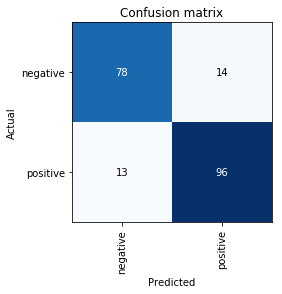

In [44]:
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()